This jupyter notebook presents a straightforward code to build an image to image translation GAN model.

# Import Required Modules

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Activation
from tensorflow.keras.layers import Flatten, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from glob import glob

from google.colab import drive

import os

# Data Preparation and Pre-Processing

## Download the Dataset from Kaggle

In [ ]:
#steps found in "https://www.kaggle.com/general/74235"
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download dansbecker/cityscapes-image-pairs

## Unzip The Dataset

In [ ]:
!unzip -q "/content/cityscapes-image-pairs.zip" -d "/content/"

## load and normalize Data Images

### Train Images

In [6]:
# Define a list to store source images for training
image_data_source = []
# Define a list to target source images for training
image_data_target = []
# Enumerate over all image files in the train folder
for image_file in glob('/cityscapes_data/cityscapes_data/train/*.jpg'):
  # Open image file
  single_image=Image.open(image_file)
  # Transform image data into an array
  img = img_to_array(single_image)
  # Normalize pixel values to the range [0, 1]
  img = img / 255.0
  # Split the image into two tensors
  input_image = img[:, :256, :]
  target_image = img[:, 256:, :]
  # Save train images in lists
  image_data_target.append(target_image)
  image_data_source.append(input_image)

width, height = 256, 256

### Test Images

In [ ]:
# Define a list to store source images for test
image_data_source_test = []
# Define a list to target source images for test
image_data_target_test = []
# Enumerate over all image files in the validation folder
for image_file in glob('/content/cityscapes_data/cityscapes_data/val/*.jpg'):
  # Open image file
  single_image=Image.open(image_file)
  # Transform image data into an array
  img = img_to_array(single_image)
  # normalize pixel values to the range [0, 1]
  img = img / 255.0
  # split the image into two tensors
  input_image = img[:, :256, :]
  target_image = img[:, 256:, :]
  # Save train images in lists
  image_data_target_test.append(input_image)
  image_data_source_test.append(target_image)

# Plot Sample of Splitted Images

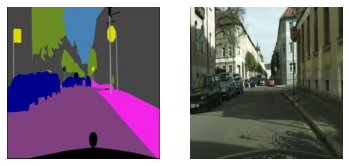

In [ ]:
# Define the subplot dimensions
fig, axs = plt.subplots(1, 2)
# plot source image in axis0
axs[0].imshow(image_data_source[0])
# plot its corredponding target image in axis1
axs[1].imshow(image_data_target[0])
axs[0].set_axis_off()
axs[1].set_axis_off()
plt.show()

# Build The Generator

In [2]:
def build_generator():
  # Define a list to store encoder output features
  encoder_tensor = []
  # Define the input shape
  inputs = Input(shape=(width, height, 3))

  # Define the first layer in encoder model
  x = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(inputs)
  x = LeakyReLU(alpha=0.2)(x)

  # Store the features out from convolution layer
  encoder_tensor.append(x)

  # Define the rest of the layers in encoder model using for loop
  for i in range(3):
    # Define the number of channels for the current layer
    channels = 2 ** (i + 6)
    x = Conv2D(channels, (3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    # Append the output tensor to the encoder tensor
    encoder_tensor.append(x)

  # Define the last layer in encoder model
  x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

  # Define the first layer in decoder model
  x = Conv2DTranspose(256, (3, 3), strides=(1, 1), padding='same')(x)
  x = BatchNormalization()(x)
  # Concatenate the output of the current decoder layer with the output of the last encoder layer
  x = Concatenate()([x, encoder_tensor[len(encoder_tensor)-1]])
  x = LeakyReLU(alpha=0.2)(x)

  # Define other layers in decoder model using for loop
  for i in range(3):
    # Define the number of channels for each layer
    channels = 512 // 2 ** (i + 1)
    x = Conv2DTranspose(channels, (3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Concatenate()([x, encoder_tensor[len(encoder_tensor)-2-i]])
    x = LeakyReLU(alpha=0.2)(x)

  # Define the last layer in decoder model
  x = Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same')(x)

  # Add activation layer
  outputs = Activation('sigmoid')(x)
  
  # Define the full encoder-decoder model
  encoder_decoder = Model(inputs, outputs)
  return encoder_decoder

In [7]:
generator = build_generator()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                             

# Build The Discriminator

In [8]:
def build_discriminator():
  # Define the inputs to the discriminator model
  input_source_image = Input(shape=(width, height, 3))
  input_target_image = Input(shape=(width, height, 3))

  # Concatenate the source and target images
  merged = Concatenate()([input_source_image, input_target_image])

  # Downsample the concatenated images
  x = Conv2D(64, kernel_size=4, strides=2, padding='same')(merged)
  x = LeakyReLU(alpha=0.2)(x)
  x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = Conv2D(512, kernel_size=4, strides=2, padding='same')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

  # Flatten and add a dense layer for classification
  x = Flatten()(x)
  output = Dense(1, activation='sigmoid')(x)

  # Create the model with the inputs and output layers
  disc_model = Model([input_source_image, input_target_image], outputs= output)

  # Compile the model with binary cross-entropy loss and Adam optimizer
  discriminator_optimizer = Adam(lr=0.0002, beta_1=0.5)
  disc_model.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer, loss_weights=[0.5])
  
  # Return the discriminator model
  return disc_model

In [9]:
discriminator = build_discriminator()
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_4 (Concatenate)    (None, 256, 256, 6)  0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

# Build Adversarial Network

In [ ]:
def build_gan(generator, discriminator):
  # Freeze the discriminator
  discriminator.trainable = False

  # define the input shape
  input_source = Input(shape=(width, height, 3))

  target_image = generator(input_source)
  validity =  discriminator([input_source, target_image])

  # Define gan model
  gan = Model(inputs=input_source, outputs=[validity, target_image])

  # compile GAN
  gan_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
  gan.compile(loss=["binary_crossentropy", "mae"], optimizer=gan_optimizer, loss_weights=[1,100])
  return gan

In [ ]:
gan_model = build_gan(generator, discriminator)
gan_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 256, 256, 3)  4510979     ['input_4[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 1)            2894273     ['input_4[0][0]',                
                                                                  'model[0][0]']                  
                                                                                            

# Print Output Images

In [ ]:
def print_generated_images(generator_model, test_source_image, test_target_image):
  # generate images based on a batch given from test data
  generated_image = generator_model(test_source_image, training=True)
  
  # Define image titles
  title = ['Input Image', 'Target Image', 'Generated Image']

  # Create a figure with three subplots
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
  
  # print only three images chosen randomly (the first three)
  for i in range(3):
    # Plot the images on their respective subplots
    ax1.imshow(test_source_image[i])
    ax2.imshow(test_target_image[i])
    ax3.imshow(generated_image[i])

    ax1.set_axis_off()
    ax2.set_axis_off()
    ax3.set_axis_off()
  
    # Add the titles to each subplot
    ax1.set_title(title[0])
    ax2.set_title(title[1])
    ax3.set_title(title[2])
    # Show the plot
    plt.show()

# Custom Training Loop

The image to image generation model is big and complex, so it requires muych time to be trained even if on GPU. For this reason model checkpoint is defined to sabe the generator, discriminator, and GAN models with their updated weights after each epoch. This will help to complete trainung from the last epoch in case if the training stopped. This will allow this model to run on machine with less computations and after each time all memory is used the training is stopped and can be completed from the last run. In addition it will help saving the model such that at any time one can see the generated images without the need to retrain the model again.

## Define check point

In [ ]:
# Load google drive to save model checkpoints
drive.mount('/content/drive')

# define the checkpoint
discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
gan_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
checkpoint_dir = '/content/drive/MyDrive'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(discriminator_opt=discriminator_optimizer,
                                 gan_opt=gan_optimizer,
                                 generator=generator,
                                 discriminator=discriminator,
                                 GAN = gan_model
                                 )
# restore last checkpoint saved
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


## Custom training loop

In [ ]:
def training(generator, discriminator, gan, epochs, batch_size):
    # to set the batch size
    steps = len(image_data_source) // batch_size

    # enumerate over epochs
    for e in range(epochs):
        # enumerate batches over the training data
        for b in range(steps):
            # create source batch images
            random_batch_index = np.random.randint(0, len(image_data_source), size = batch_size)
            source_images = [image_data_source[i] for i in random_batch_index]
            # source_images = source_images.reshape((batch_size, width, height, 3))
            reshaped_source_images = tf.reshape(source_images, (batch_size, width, height, 3))

            # create target batch images
            target_images = [image_data_target[i] for i in random_batch_index]
            # target_images = target_images.reshape((batch_size, width, height, 3))
            reshaped_target_images = tf.reshape(target_images, (batch_size, width, height, 3))

            # create fake images by the generator
            fake_target_images = generator.predict(reshaped_source_images)


            # generate fake labels generated images as zeros
            fake_labels = np.zeros([batch_size, 1])
            # generate real labels for real data as ones
            real_labels = np.ones([batch_size, 1])*0.9

            # Calculate the loss of real data points
            discriminator_loss_real = discriminator.train_on_batch([reshaped_source_images, reshaped_target_images], real_labels)
            # Calculate the loss of generated data points
            discriminator_loss_fake = discriminator.train_on_batch([reshaped_source_images, fake_target_images], fake_labels)
            # Compute total discriminator loss
            discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)

            # calculate the generator loss
            indices = np.random.randint(0, len(image_data_source), size=batch_size)
            source_images = [image_data_source[i] for i in indices]
            reshaped_source_images = np.reshape(source_images, (batch_size, width, height, 3))
            target_images = [image_data_target[i] for i in indices]
            reshaped_target_images = np.reshape(target_images, (batch_size, width, height, 3))
            y_gan = np.ones((batch_size, 1))
            generator_loss, _, _ = gan.train_on_batch(reshaped_source_images, [y_gan, reshaped_target_images])

            # if the remainder of dividing current epoch number by 10 equal to 0 print the following image
            if e % 10 == 0:
                print('Epoch: ', e, ' Generator Loss: ', generator_loss, ' Discriminator Loss: ', discriminator_loss)

        if e% 1 == 0 :
          ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)
          k = e
          ckpt_manager.save(checkpoint_number=k)
        # if this is the last ephoch print the generated images
        if e % 10 == 0 or e == epochs-1:
            test_indices = np.random.randint(0, len(image_data_source_test), size = batch_size//2)
            test_source = [image_data_source_test[i] for i in test_indices]
            reshaped_source_test = tf.reshape(test_source, (batch_size//2, width, height, 3))
            test_target = [image_data_target_test[i] for i in test_indices]
            reshaped_target_test = tf.reshape(test_target, (batch_size//2, width, height, 3))
            print_generated_images(generator, reshaped_source_test, reshaped_target_test)

# Call Training Loop

In [9]:
training(generator, discriminator, gan_model, 10000, 128) 